# Build Detectron2

In [ ]:
!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-iy2f7quj
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-iy2f7quj
  Resolved https://github.com/facebookresearch/detectron2.git to commit 8d85329aed8506ea3672e3e208971345973ea761
  Preparing metadata (setup.py) ... done


In [ ]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# importing data

In [ ]:
!pip install gdown

In [ ]:
!gdown --id 1h8f70cpDvEZHmuWmr5akCkAbJITTVCQF

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Traceback (most recent call last):
  File "/usr/local/bin/gdown", line 8, in <module>
    sys.exit(main())
  File "/usr/local/lib/python3.10/dist-packages/gdown/__main__.py", line 172, in main
    download(
  File "/usr/local/lib/python3.10/dist-packages/gdown/download.py", line 202, in download
    res = sess.get(url, stream=True, verify=verify)
  File "/usr/local/lib/python3.10/dist-packages/requests/sessions.py", line 602, in get
    return self.request("GET", url, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/requests/sessions.py", line 589, in request
    resp = self.send(prep, **send_kwargs)
  File "/usr/local/lib/python3.10/dist-packages/requests/sessions.py", line 703, in send
    r = adapter.send(request, **kwargs)
  File "/usr/local/lib/python3.10

In [ ]:
!unzip pant_ds-no-aug-20241025T143249Z-001.zip

Archive:  pant_ds-no-aug-20241025T143249Z-001.zip
  inflating: pant_ds -no aug/labels/val.cache  
  inflating: pant_ds -no aug/images/test/test-44.jpg  
  inflating: pant_ds -no aug/images/test/test-23.jpg  
  inflating: pant_ds -no aug/images/test/test-28.jpg  
  inflating: pant_ds -no aug/images/test/test-40.jpg  
  inflating: pant_ds -no aug/images/test/test-47.jpg  
  inflating: pant_ds -no aug/images/test/test-39.jpg  
  inflating: pant_ds -no aug/images/test/test-31.jpg  
  inflating: pant_ds -no aug/labels/test/test-3.txt  
  inflating: pant_ds -no aug/images/test/test-35.jpg  
  inflating: pant_ds -no aug/labels/test/test-6.txt  
  inflating: pant_ds -no aug/images/test/test-27.jpg  
  inflating: pant_ds -no aug/images/test/test-25.jpg  
  inflating: pant_ds -no aug/images/test/test-33.jpg  
  inflating: pant_ds -no aug/images/test/test-26.jpg  
  inflating: pant_ds -no aug/images/test/test-22.jpg  
  inflating: pant_ds -no aug/images/test/test-41.jpg  
  inflating: pant_ds -no

In [ ]:
import json
import os
from PIL import Image

# Paths to images and labels
images_path = "/content/pant_ds-no-aug/images/test" # run for train test and val
labels_path = "/content/pant_ds-no-aug/labels/test"
output_json_path = "coco_annotations_test.json"

# Dataset metadata
categories = [{"id": 1, "name": "pant", "supercategory": "pant", "keypoints": ["keypoint1", "keypoint2", "..."], "skeleton": []}]

# Initialize COCO JSON structure
coco_data = {
    "images": [],
    "annotations": [],
    "categories": categories
}

# Helper function to convert YOLO format to COCO format
def yolo_to_coco_bbox(x_center, y_center, width, height, img_width, img_height):
    x = (x_center - width / 2) * img_width
    y = (y_center - height / 2) * img_height
    w = width * img_width
    h = height * img_height
    return [x, y, w, h]

# Process each annotation file
annotation_id = 1
image_id = 1

for label_file in os.listdir(labels_path):
    if not label_file.endswith(".txt"):
        continue

    # Get corresponding image file and dimensions
    image_file = label_file.replace(".txt", ".jpg")
    image_path = os.path.join(images_path, image_file)
    if not os. path. isfile(image_path):
        continue
    with Image.open(image_path) as img:
        img_width, img_height = img.size

    # Add image data to COCO JSON
    coco_data["images"].append({
        "id": image_id,
        "width": img_width,
        "height": img_height,
        "file_name": image_file
    })

    # Read YOLO annotation file
    with open(os.path.join(labels_path, label_file), "r") as f:
        for line in f:
            values = line.strip().split()
            class_id = int(values[0])
            x_center, y_center, width, height = map(float, values[1:5])

            # Convert bounding box to COCO format
            bbox = yolo_to_coco_bbox(x_center, y_center, width, height, img_width, img_height)
            area = bbox[2] * bbox[3]

            # Process keypoints and visibility flags
            keypoints = []
            num_keypoints = 0
            for i in range(5, len(values), 3):
                x_kp, y_kp, v_kp = map(float, values[i:i+3])
                x_kp = int(x_kp * img_width)
                y_kp = int(y_kp * img_height)
                v_kp = int(v_kp)
                keypoints.extend([x_kp, y_kp, v_kp])
                if v_kp > 0:
                    num_keypoints += 1

            # Add annotation data to COCO JSON
            coco_data["annotations"].append({
                "id": annotation_id,
                "image_id": image_id,
                "category_id": class_id + 1,  # Adjust if needed
                "bbox": bbox,
                "area": area,
                "iscrowd": 0,
                "keypoints": keypoints,
                "num_keypoints": num_keypoints
            })

            annotation_id += 1
    image_id += 1

# Save COCO JSON to file
with open(output_json_path, "w") as outfile:
    json.dump(coco_data, outfile, indent=4)

print(f"Conversion complete! COCO JSON saved to {output_json_path}")


Conversion complete! COCO JSON saved to coco_annotations_test.json


## Run a Mask RCNN  detectron2 model on Custom Dataset

### 1st Step: Register your  dataset to detectron2

Register your dataset (i.e., tell detectron2 how to obtain your dataset).

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

In [ ]:
from detectron2.data.datasets import register_coco_instances


register_coco_instances("pants_train", {}, "/content/coco_annotations_train.json", "/content/pant_ds-no-aug/images/train")

register_coco_instances("pants_test", {}, "/content/coco_annotations_test.json", "/content/pant_ds-no-aug/images/test")

In [ ]:
from detectron2.data import MetadataCatalog

keypoint_names = ['a', 'b', 'c', 'd', 'e', 'f','g','h','i','j','k','l','m']
keypoint_flip_map = [('a', 'c'), ('d', 'f')] # keep empty for the moment

from detectron2.data import MetadataCatalog
classes = MetadataCatalog.get("pants_train").thing_classes = ["pant"]
print(classes)

['pant']


In [ ]:

MetadataCatalog.get("pants_train").thing_classes = ["pant"]
MetadataCatalog.get("pants_train").thing_dataset_id_to_contiguous_id = {1:0}
MetadataCatalog.get("pants_train").keypoint_names = keypoint_names
MetadataCatalog.get("pants_train").keypoint_flip_map = keypoint_flip_map
MetadataCatalog.get("pants_train").evaluator_type="coco"


In [ ]:
dataset_dicts = DatasetCatalog.get("pants_train")
dataset_dicts

[10/27 16:49:05 d2.data.datasets.coco]: Loaded 541 images in COCO format from /content/coco_annotations_train.json


[{'file_name': '/content/pant_ds-no-aug/images/train/train-396.jpg',
  'height': 3072,
  'width': 4096,
  'image_id': 1,
  'annotations': [{'iscrowd': 0,
    'bbox': [1076.7994879999999, 415.8182399999999, 2775.330816, 2355.710976],
    'keypoints': [1586.5,
     437.5,
     2,
     2144.5,
     583.5,
     2,
     2629.5,
     415.5,
     2,
     2743.5,
     858.5,
     2,
     2153.5,
     1032.5,
     2,
     1524.5,
     949.5,
     2,
     1488.5,
     1065.5,
     2,
     1076.5,
     2677.5,
     2,
     1491.5,
     2771.5,
     2,
     2193.5,
     1202.5,
     2,
     3837.5,
     1064.5,
     2,
     3852.5,
     1463.5,
     2,
     2770.5,
     1068.5,
     2],
    'category_id': 0,
    'bbox_mode': <BoxMode.XYWH_ABS: 1>}]},
 {'file_name': '/content/pant_ds-no-aug/images/train/train-293.jpg',
  'height': 4096,
  'width': 3072,
  'image_id': 2,
  'annotations': [{'iscrowd': 0,
    'bbox': [1070.811648, 1428.89984, 1896.619008, 1873.89952],
    'keypoints': [1073.5,
     15

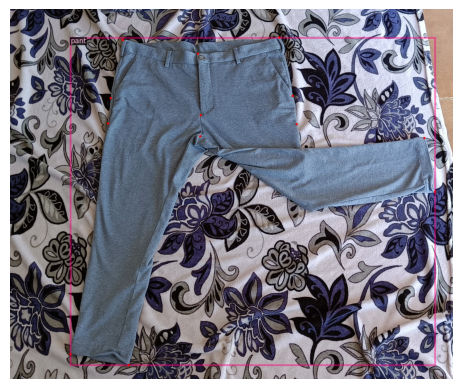

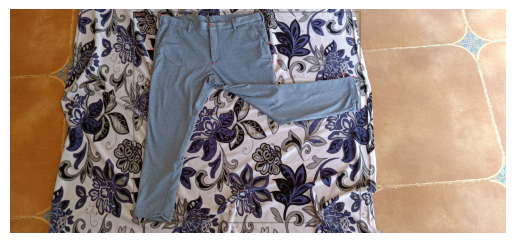

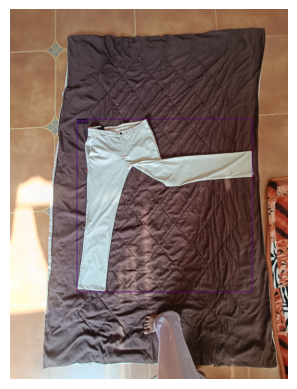

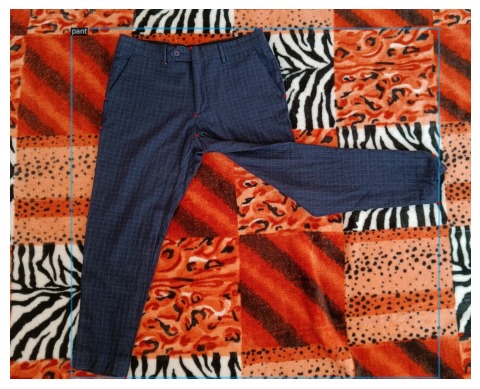

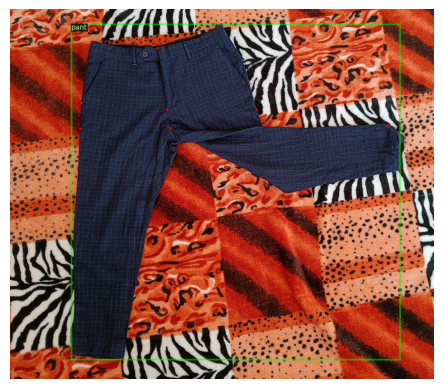

In [ ]:
# To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the dataset:
import random
from detectron2.utils.visualizer import Visualizer

pants_metadata = MetadataCatalog.get("pants_train")

def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(), plt.imshow(im), plt.axis('off');

for d in random.sample(dataset_dicts, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=pants_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

# Training

In [ ]:

from detectron2.engine import DefaultTrainer

cfg = get_cfg()
#cfg.MODEL.DEVICE = "cpu"


cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("pants_train",)


#cfg.DATASETS.TEST = ("pant_test",)  #Dataset 'pant_test' is empty in my case
cfg.DATASETS.TEST = ()

cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MAX_ITER = 500  # Iterations to train for
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 2048   #(default: 512)

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # pant
cfg.MODEL.RETINANET.NUM_CLASSES = 1
cfg.MODEL.ROI_KEYPOINT_HEAD.NUM_KEYPOINTS = 13
cfg.TEST.KEYPOINT_OKS_SIGMAS = np.ones((13, 1), dtype=float).tolist()


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)    #CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


[10/27 16:51:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.keypoint_head.score_lowres.{bias, weight}


[10/27 16:51:39 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.10/dist-packages/detectron2/structures/keypoints.py:29: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  keypoints = torch.as_tensor(keypoints, dtype=torch.float32, device=device)
/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Tr

[10/27 16:52:14 d2.utils.events]:  eta: 0:11:12  iter: 19  total_loss: 8.195  loss_cls: 0.06541  loss_box_reg: 0.0307  loss_keypoint: 8.093  loss_rpn_cls: 0.005727  loss_rpn_loc: 0.01203    time: 1.6261  last_time: 1.2095  data_time: 0.4009  last_data_time: 0.0277   lr: 9.7405e-06  max_mem: 5070M
[10/27 16:52:50 d2.utils.events]:  eta: 0:11:16  iter: 39  total_loss: 8.181  loss_cls: 0.0512  loss_box_reg: 0.02473  loss_keypoint: 8.087  loss_rpn_cls: 0.00389  loss_rpn_loc: 0.009911    time: 1.6239  last_time: 2.3920  data_time: 0.3168  last_data_time: 1.2209   lr: 1.9731e-05  max_mem: 5071M
[10/27 16:53:24 d2.utils.events]:  eta: 0:11:06  iter: 59  total_loss: 8.165  loss_cls: 0.05199  loss_box_reg: 0.02853  loss_keypoint: 8.064  loss_rpn_cls: 0.002369  loss_rpn_loc: 0.01103    time: 1.6411  last_time: 1.4302  data_time: 0.2525  last_data_time: 0.0247   lr: 2.972e-05  max_mem: 5071M
[10/27 16:53:57 d2.utils.events]:  eta: 0:10:36  iter: 79  total_loss: 8.126  loss_cls: 0.05024  loss_box_

In [ ]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.visualizer import ColorMode
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

#We are using the pre-trained Detectron2 model, as shown below.
cfg = get_cfg()
cfg.MODEL.DEVICE = 'cuda' # "cpu"

# load the pre trained model from Detectron2 model zoo
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7 # set a custom testing threshold


def cv2_imshow(im):
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(25,7.5)), plt.imshow(im), plt.axis('off');


predictor = DefaultPredictor(cfg)
im = cv2.imread("/content/pant_ds -no aug/images/test/test-1.jpg")

outputs = predictor(im)
print(outputs)
o = outputs["instances"]
print("###########################################################")



idxofClass = [i for i, x in enumerate(list(outputs['instances'].pred_classes)) if x == 15]

#Create new class, boxes, scores & masks
classes = o.pred_classes[idxofClass]
scores = o.scores[idxofClass]
boxes = o.pred_boxes[idxofClass]
#masks = o.pred_masks[idxofClass]

#Define new instance and set the new values to new instance. Note: detectron2 module provides this method set.
obj = detectron2.structures.Instances(image_size=(480, 640))

obj.set('pred_classes', classes)
obj.set('scores', scores)
obj.set('pred_boxes', boxes)
#obj.set('pred_masks', masks)

# out = v.draw_instance_predictions(obj.to("cpu"))


[10/27 16:41:04 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


/usr/local/lib/python3.10/dist-packages/fvcore/common/checkpoint.py:252: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(f, map_location=torch.device("cpu"))

{'instances': Instances(num_instances=11, image_height=3264, image_width=2448, fields=[pred_boxes: Boxes(tensor([[   0.0000,    0.0000, 2448.0000, 3264.0000],
        [   0.0000,    0.0000,  491.5377, 3264.0000],
        [  48.3354,    0.0000, 1093.3021, 3264.0000],
        [2256.6523,    0.0000, 2448.0000, 3264.0000],
        [2371.0295,    0.0000, 2448.0000, 3264.0000],
        [2005.2480,    0.0000, 2448.0000, 3264.0000],
        [  59.5840,    0.0000,  179.0252, 3264.0000],
        [   4.5844,    0.0000,   12.6646, 3264.0000],
        [  42.4649,    0.0000,  116.2880, 3264.0000],
        [  28.8792,    0.0000,   79.6147, 3264.0000],
        [  13.4027,    0.0000,   35.0403, 3264.0000]], device='cuda:0')), scores: tensor([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.], device='cuda:0'), pred_classes: tensor([15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 15], device='cuda:0')])}
###########################################################


In [ ]:
im = cv2.imread("/content/pant_ds -no aug/images/test/test-1.jpg")
outputs = predictor(im)
print(outputs)
v = Visualizer(im[:, :, ::-1],
                metadata=None,
                scale=0.75,
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

In [ ]:
v = Visualizer(im[:, :, ::-1],
                   metadata=pants_metadata,
                   scale=0.8,
                  #  instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()